In [81]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
import category_encoders as ce

#используем библиотеку, которая позволяет анализировать тональность текста
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

pd.set_option('display.max_columns', 100) #чтобы всё отображалось

!pip freeze > requirements.txt

RANDOM_SEED = 42 #фиксируeм RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы

hotels = pd.read_csv('hotels.csv')
key_countries = ['United Kingdom', 'Unites States']
hotels['country_to_delete'] = hotels['hotel_address'].apply(lambda x: x.split()[-2] + ' ' + x.split()[-1])
hotels['country'] = hotels['country_to_delete'].apply(lambda x: x if x in key_countries else x.split()[-1])

hotels.drop(['country_to_delete'], axis=1, inplace=True)

gini_data = pd.read_csv('./data_csv.csv') #получаем датасет Всемирного банка

#функция, по признаку Страны получаем последнее (актуальное) значение года
def last_year(feature):
    return gini_data[gini_data['Country Name'] == feature]['Year'].tolist()[-1]

gini_data['max_year'] = gini_data['Country Name'].apply(last_year) #создаём новый признак актуального года
gini_data.rename(columns={'Country Name': 'country', 'Value': 'gini'}, inplace=True) #переименовывем признаки для удобства

#оставляем только данные, у которых год наблюдения совпадает с его последним значением
gini_data = gini_data[gini_data['Year'] == gini_data['max_year']][['country', 'gini']]
gini_data = gini_data.set_index('country') #уберём индексы для присоеднинения по join-у

country_population = pd.read_csv('./country_population.csv', sep=';') #загружаем используемый на курсе датасает по населению
country_population = country_population.set_index('country')

hotels = hotels.join(gini_data, on=['country'])
hotels = hotels.join(country_population, on=['country'])

hotels.drop(['lat', 'lng'], axis=1, inplace=True)

nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer() #измерим тональность негативного и позитивного отзывов, создадим признаки
hotels['positive'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['negative'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])

hotels.drop(['positive_review', 'negative_review'], axis=1, inplace=True)

hotels['population'] = hotels['population'].apply(lambda x: ''.join(x.split(',')))
hotels['population'] = hotels['population'].astype(int)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\grish\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'reviewer_score'}>,
        <AxesSubplot:title={'center':'gini'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'positive'}>,
        <AxesSubplot:title={'center':'negative'}>, <AxesSubplot:>]],
      dtype=object)

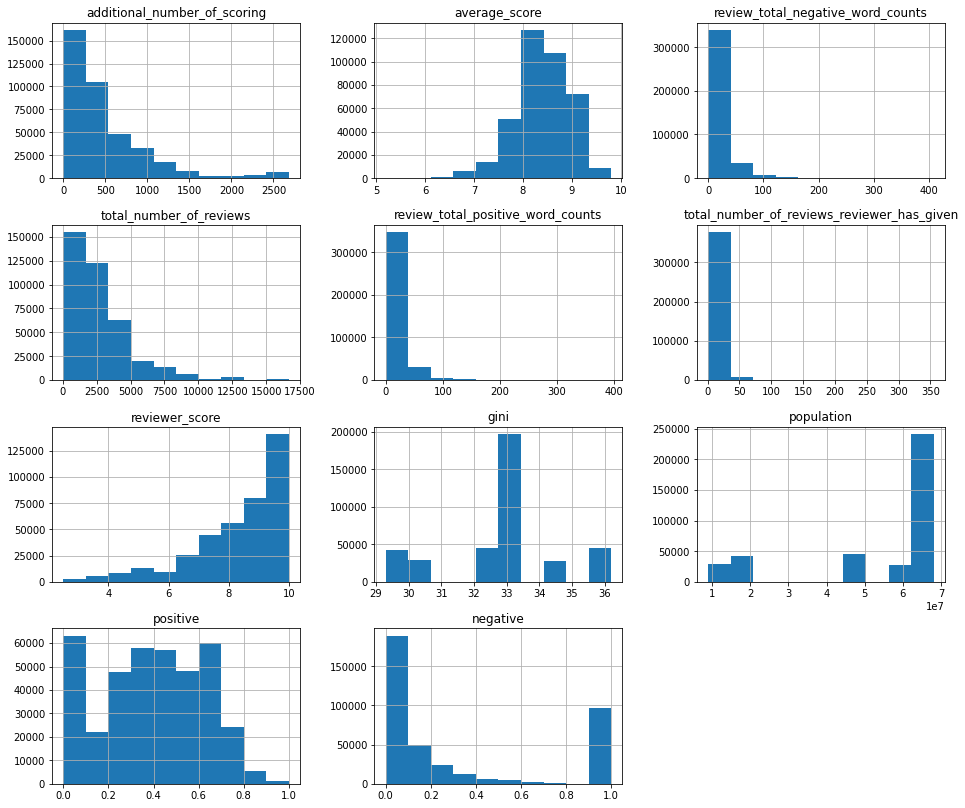

In [82]:
hotels.hist(figsize=(16,14))

In [84]:
#Наблюдается разброс в значениях, есть риск, что модель отвлечётся на более тяжёные признаки. Проведём масштабирование
#Создание экземпляра класса RobustScaler()
robust_scaler = preprocessing.RobustScaler()
#Масштабирование признака
hotels['population'] = robust_scaler.fit_transform(hotels[['population']])
hotels['total_number_of_reviews'] = robust_scaler.fit_transform(hotels[['total_number_of_reviews']])
hotels['total_number_of_reviews_reviewer_has_given'] = robust_scaler.fit_transform(hotels[['total_number_of_reviews_reviewer_has_given']])
hotels['review_total_negative_word_counts'] = robust_scaler.fit_transform(hotels[['review_total_negative_word_counts']])
hotels['review_total_positive_word_counts'] = robust_scaler.fit_transform(hotels[['review_total_positive_word_counts']])

#Создание экземпляра класса MinMaxScaler(), диапазон {0,1}
minmax_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
#Масштабирование признака
hotels['additional_number_of_scoring'] = minmax_scaler.fit_transform(hotels[['additional_number_of_scoring']])
hotels['gini'] = minmax_scaler.fit_transform(hotels[['gini']])

# Создание экземпляра класса StandardScaler()
standard = preprocessing.StandardScaler()
# Стандартизация признака
hotels['average_score'] = standard.fit_transform(hotels[['average_score']])

array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'reviewer_score'}>,
        <AxesSubplot:title={'center':'gini'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'positive'}>,
        <AxesSubplot:title={'center':'negative'}>, <AxesSubplot:>]],
      dtype=object)

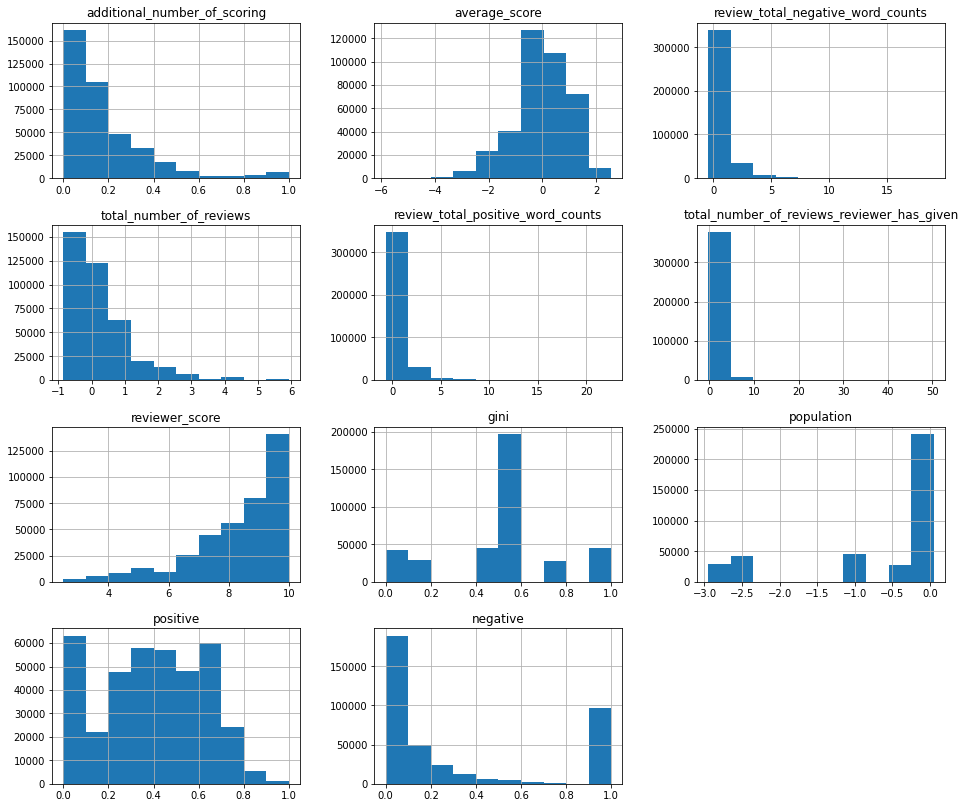

In [85]:
hotels.hist(figsize=(16,14)) #после масштабирования

Text(0.5, 1.0, 'Тепловая карта числовых признаков')

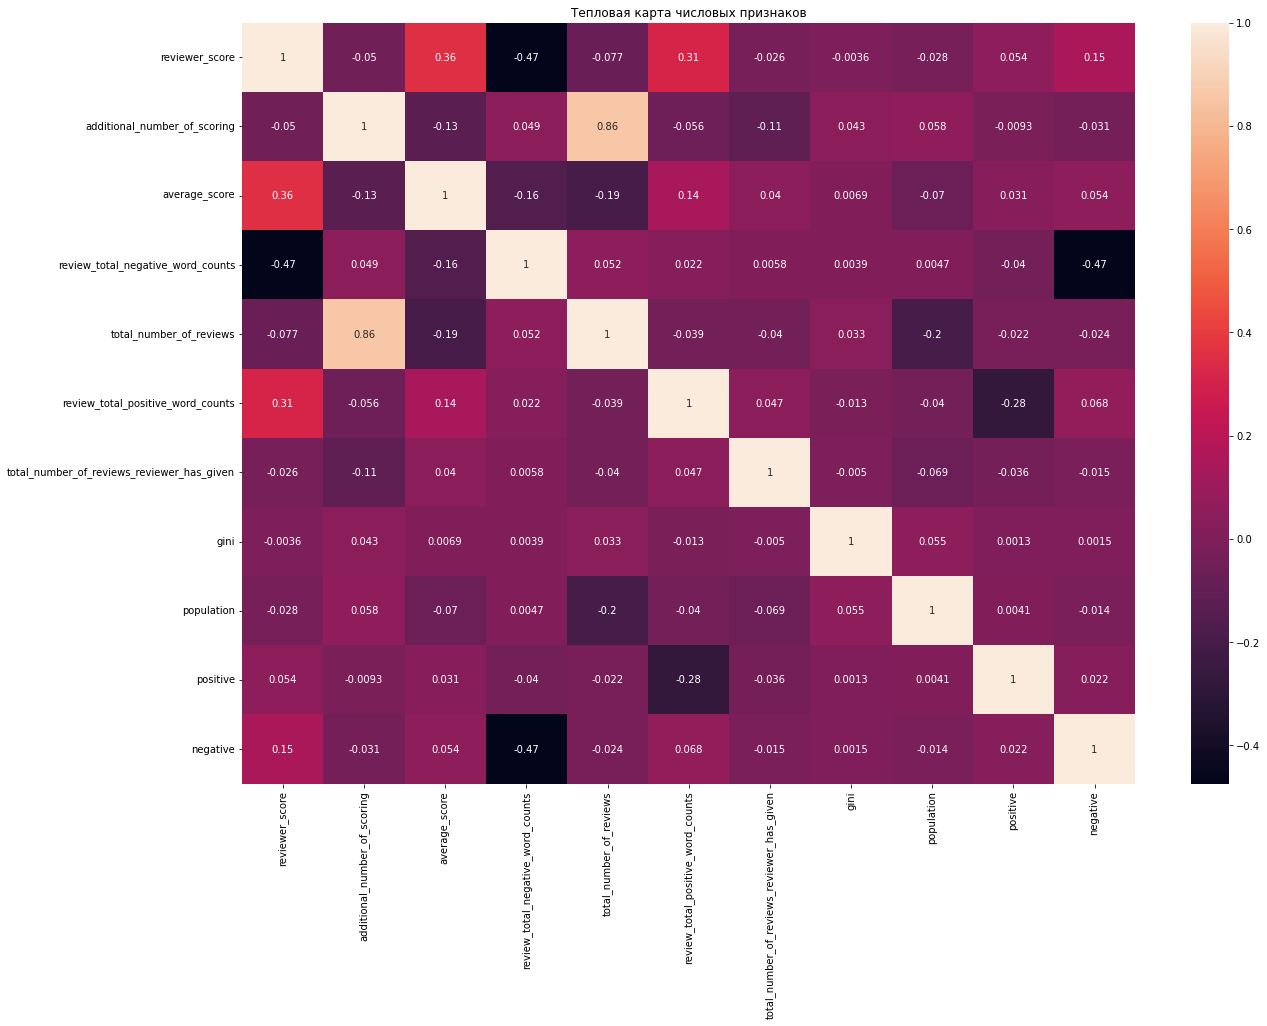

In [86]:
numeric = ['reviewer_score', 'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',
          'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
          'gini', 'population', 'positive', 'negative']

fig = plt.figure(figsize=(20, 14))
ax = sns.heatmap(data = hotels[numeric].corr(method = 'spearman'), annot = True) 
ax.set_title('Тепловая карта числовых признаков')

In [87]:
# Создание экземпляра класса BinaryEncoder()
bin_enc = ce.BinaryEncoder(cols=['hotel_name', 'reviewer_nationality']) #будем кодировать признаки отеля и нац-ти ревьюера
data_bin = bin_enc.fit_transform(hotels[['hotel_name', 'reviewer_nationality']])
hotels = pd.concat([hotels, data_bin], axis=1)

cols_to_delete = ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 
                     'tags', 'days_since_review', 'country']

hotels.drop(cols_to_delete, axis=1, inplace=True)

In [94]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [97]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring', 'total_number_of_reviews', 'review_total_negative_word_counts', 
            'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 
           'population']

# категориальные признаки
cat_cols = ['gini', 'positive', 'negative', 'hotel_name_0', 'hotel_name_1',
       'hotel_name_2', 'hotel_name_3', 'hotel_name_4', 'hotel_name_5',
       'hotel_name_6', 'hotel_name_7', 'hotel_name_8', 'hotel_name_9',
       'hotel_name_10', 'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2', 'reviewer_nationality_3',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewer_nationality_6', 'reviewer_nationality_7']

y_analyse = y.astype('int') #отдельная выборка для проведения анализов

<AxesSubplot:>

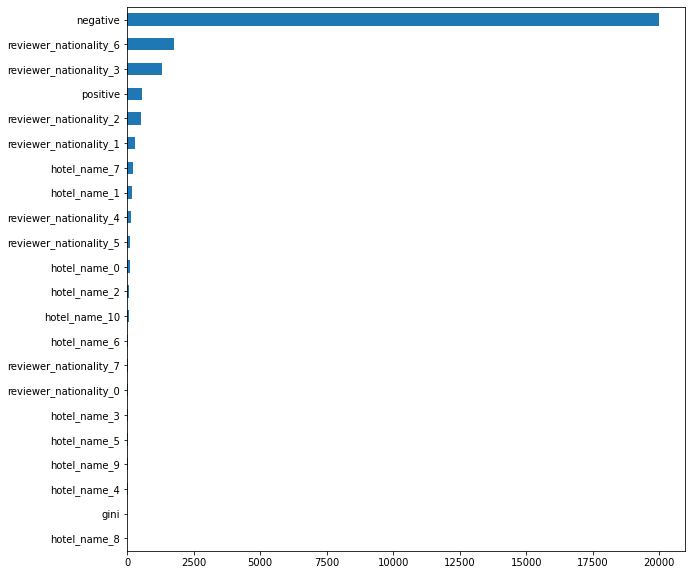

In [98]:
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y_analyse)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

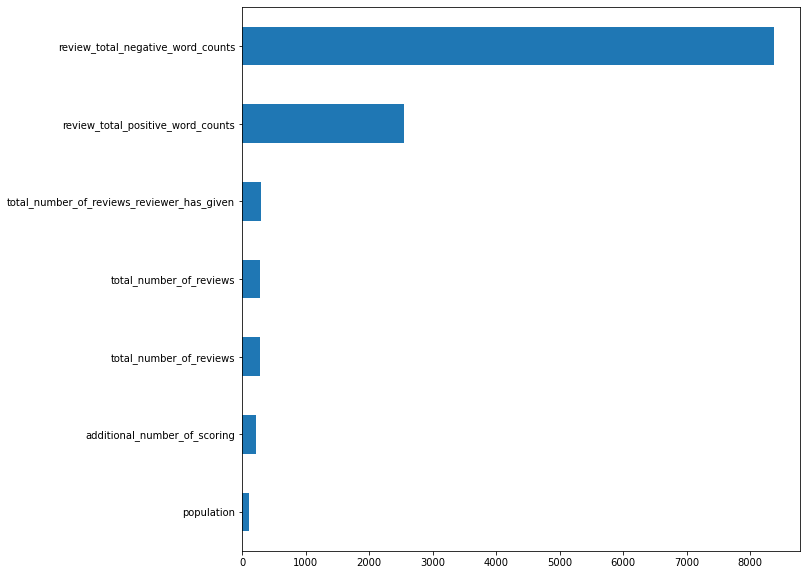

In [99]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y_analyse)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [95]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split 

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s


MAPE: 0.1296458030647561


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


<AxesSubplot:>

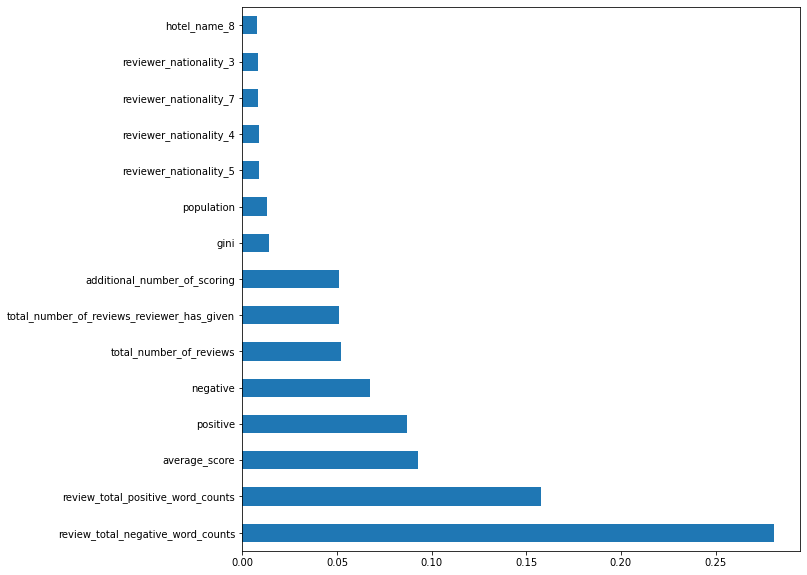

In [96]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')